# [Accelerate](https://huggingface.co/docs/accelerate/usage_guides/explore)
- 모델이 커지면서 병렬 처리는 제한된 하드웨어에서 더 큰 모델을 훈련하고 훈련 속도를 몇 배로 가속화하기 위한 전략으로 등장했습니다.
- Hugging Face에서는 사용자가 하나의 머신에 여러 개의 GPU를 사용하든 여러 머신에 여러 개의 GPU를 사용하든 모든 유형의 분산 설정에서 🤗 Transformers 모델을 쉽게 훈련할 수 있도록 돕기 위해 🤗 Accelerate 라이브러리를 만들었습니다.

## 특징
- 단 4줄의 코드만 추가하면 Multi GPU 분산 구성을 똑같이 100%로 활용할 수 있다.
- 기본 pytorch 코드를 통해 multi gpu를 사용하면(DDP) 0번 gpu만 100퍼센트 사용되고 나머지 GPU는 예를 들어 60% 정도씩 덜 활용된다.
- 각 GPU에서 loss를 계산하고 각 결과를 합해서 최종 loss를 구해야 하는데 합하는 연산을 0번 device에서 하기 때문에 0번의 소모만 커지기 때문이다.
- accelerate을 사용하면 이러한 문제를 해결할 수 있다. nvidia-smi를 찍어보면 모든 GPU가 100% 활용되고 있는 것을 확인할 수 있다.

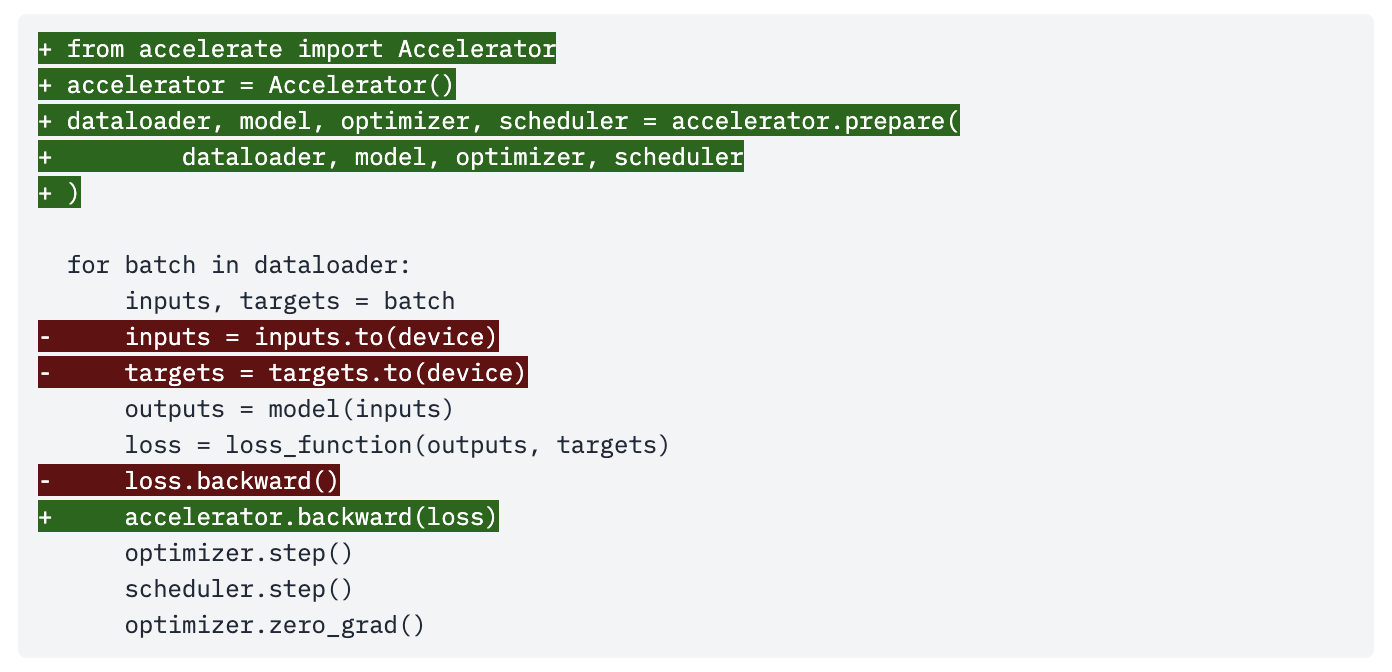

## [대규모 모델 학습할 때에 고려할 요소들](https://littlefoxdiary.tistory.com/126)

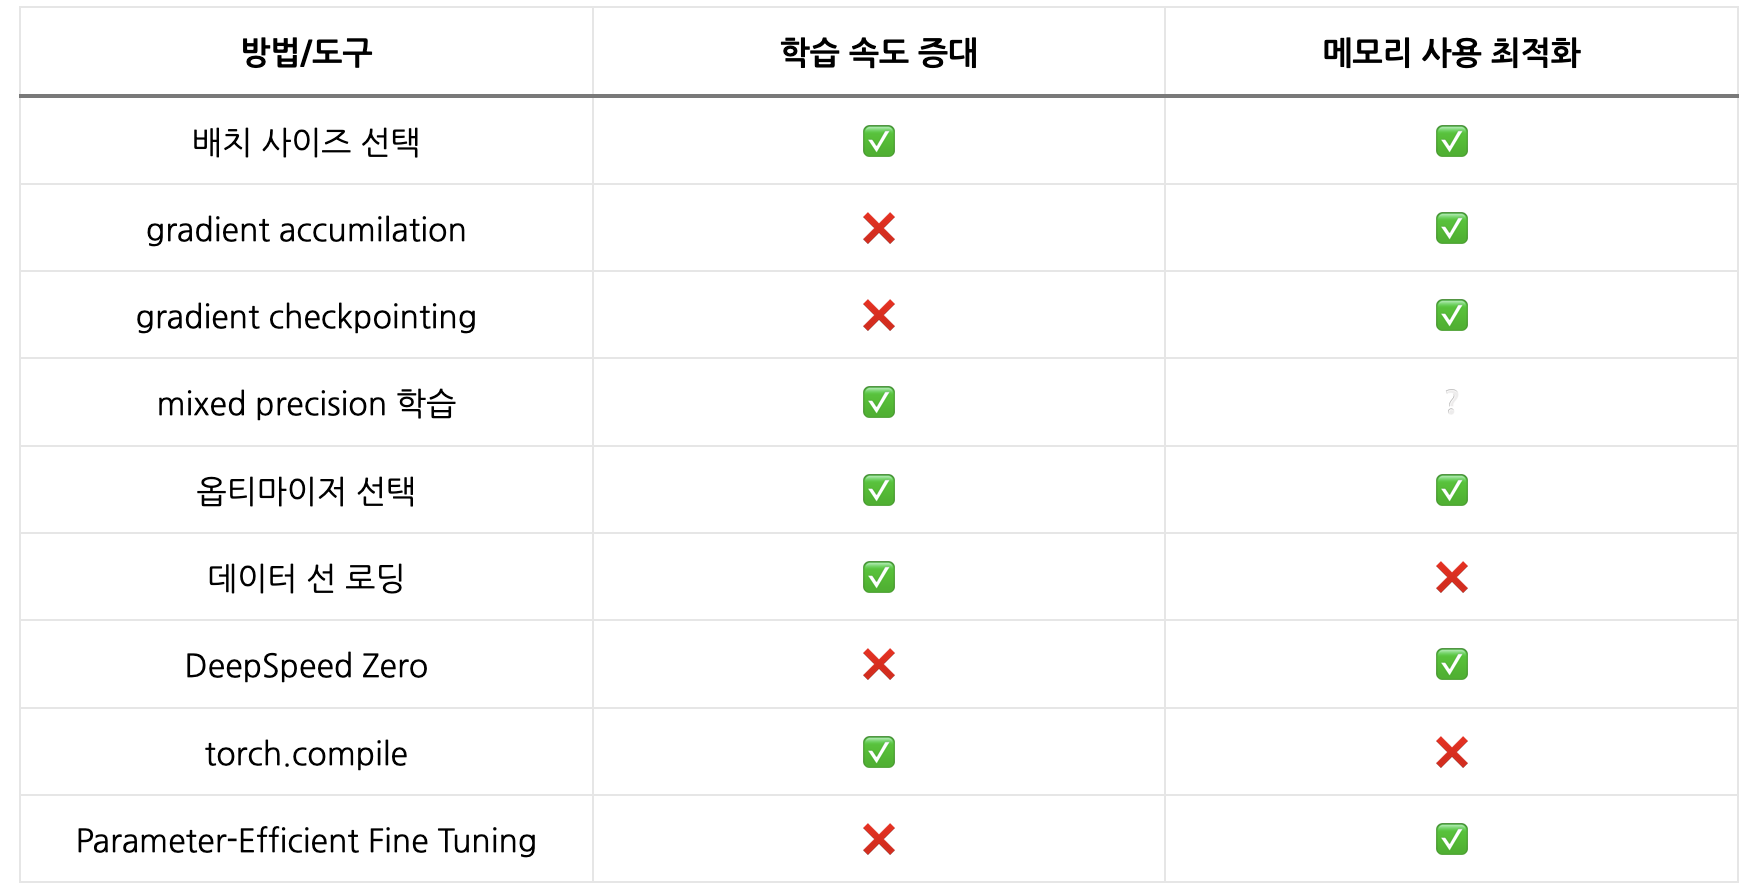

### 배치사이즈 선택

- 모델 학습 속도와 메모리 활용의 효율성을 증대하기 위한 최적화 기법을 이해하기 위해, 최적의 성능을 얻기 위해 먼저 적절한 배치 크기를 식별해야 한다. 배치 크기와 입력/출력 뉴런 수는 크기가 2의 승수에 해당하는 것이 좋다. 8의 배수를 일반적으로 사용할 수 있지만, 사용 중인 하드웨어와 모델의 dtype에 따라 더 높은 숫자를 선택하는 것이 가능하다.
- General Matrix Multiplication(GEMM)에 포함되어 있는 fully connected layer에 대한 입력/출력 뉴런 수 및 배치 사이즈에 대한 해서는 NVIDIA의 권장 사항을 확인해보면 좋다.
- Tensor Core Requirements는 dtype과 하드웨어를 기반으로 승수를 정의한다. 예를 들어 fp16 데이터의 경우 A100 GPU의 경우 64의 배수, 이외 GPU에서는 8의 배수를 권장한다.
- 작은 파라미터의 경우 Dimension Qualtization Effects를 고려할 수도 있다. 이는 타일링이 발생하는 지점이며, 올바른 승수를 사용하는 것이 상당한 속도 향상에 기여할 수 있다.



### Gradient Accumulation

- 그래디언트 누적 방법은 전체 배치에 대해 그래디언트를 한 번에 계산하는 대신 더 작은 단위로 계산하는 것을 목표로 한다. 이 방식은 forward 및 backward pass를 수행하고 프로세스 중에 그래디언트를 누적하여 더 작은 배치에서 반복적으로 그래디언트를 계산하는 것을 포함한다. 충분한 그래디언트가 누적되면 모델의 optimization 단계를 수행한다. 그래디언트 누적을 사용하면 GPU의 메모리 용량에 의해 부과되는 한계를 넘어 유효 배치 크기를 늘릴 수 있디. 그러나 그래디언트 누적에 의해 추가로 도입된 순방향 및 역방향 패스는 학습 프로세스를 느리게 만들 수 있다는 점에 유의해야 한다.
- Gradient_accumulation_steps 인수를 TrainingArguments에 추가하여 그라디언트 누적을 활성화할 수 있다:
```python
training_args = TrainingArguments(per_device_train_batch_size=1,
                                    gradient_accumulation_steps=4,
                                    **default_args)
```

위 코드에서 유효 배치 사이즈는 4가 된다.

### Gradient Checkpointing

- 배치 크기를 1로 설정하고 그래디언트 누적을 사용하더라도 일부 대규모 모델에서는 메모리 문제가 생길 수 있다.
- 메모리 저장이 필요한 다른 구성 요소도 있기 때문이다.
- Backward pass 동안 그래디언트를 계산하기 위해 모든 activation을 forward pass에서 저장하면 메모리 오버헤드가 크게 발생할 수 있다. 하지만 대안으로 backward pass를 진행하는 동안 activation 값을 버린 다음 다시 필요할 때 수행하게 되면, 상당한 계산 부하가 걸리고 학습 프로세스의 속도를 늦출 것이다.
- 그래디언트 체크포인팅은 이 두 가지 접근 방식 사이의 절충점을 제공하고 계산 그래프 전반에 걸쳐 전략적으로 선택된 활성화를 저장하므로 activation의 일부만 그래디언트에 대해 다시 계산하면 된다.
- 그라디언트 체크포인팅을 사용하기 위해서는 해당 플래그를 TraningArguments에 전달하면 된다:
```python
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    **default_args
)
```
Gradient checkpointing은 메모리 효율성을 증가시킬 수 있으나, 학습 속도를 약 20%가량 저하시킨다.

### Mixed precision training

- 혼합 정밀 학습은 특정 변수에 대해 더 낮은 정밀도의 수치 형식을 사용하여 모델의 계산 효율을 최적화하는 기법이다. 전통적으로 대부분의 모델은 변수를 표현하고 처리하기 위해 32비트 부동 소수점 정밀도(fp32 또는 float32)를 사용한다. 그러나 모든 변수가 정확한 결과를 얻기 위해 이 높은 정밀도 수준을 필요로 하는 것은 아니다. 특정 변수의 정밀도를 줄여 16비트 부동 소수점(fp16 또는 float16)과 같은 더 낮은 수치 형식으로 계산하면 계산 속도를 높일 수 있다. 이 접근 방식에서는 일부 계산이 반 정밀도로 수행되는 반면 일부 계산은 여전히 완전 정밀도를 사용하기 때문에 혼합 정밀 훈련이라고 부른다.
- 대부분의 혼합 정밀도 훈련은 fp16(float16) 데이터 유형을 사용하여 이루어지지만, 일부 GPU 아키텍처(Ampere 아키텍처 등)는 bf16 및 tf32(CUDA 내부 데이터 유형) 데이터 유형을 제공한다. 이러한 데이터 유형 간의 차이점에 대한 자세한 내용은 [NVIDIA Blog](https://developer.nvidia.com/blog/accelerating-ai-training-with-tf32-tensor-cores/)를 통해 확인할 수 있다.

### BF16

- Ampere 이상의 하드웨어에서는 bf16을 사용해 혼합 정밀도 학습 및 평가를 할 수 있다.  bf16은 fp16보다 정밀도가 떨어지지만 동적 범위는 훨씬 크다. fp16에서 가질 수 있는 가장 큰 수는 65535이며 그 이상의 수는 오버플로우를 일으킨다. bf16 수는 fp32와 거의 동일한 3.39e+38(!)만큼 가질 수 있는데, 둘 다 수치 범위에 사용되는 8비트를 가지고 있기 때문이다.
- BF16은 HF Trainer에서 활성화할 수 있다:
```python
training_args = TrainingArguments(bf16=True, **default_args)
```

### TF32

- Ampere 하드웨어는 tf32라는 데이터 형식을 사용한다. fp32(8비트)와 같은 숫자 범위를 갖지만 23비트 정밀도 대신 10비트(fp16과 동일)만 사용하며, 총합 19비트 만을 사용한다. 일반 fp32 훈련 및/또는 추론 코드를 사용할 수 있고 tf32 지원을 활성화하면 최대 3배의 처리량 향상을 얻을 수 있다는 점에서 "magical"하다. 코드에 다음을 추가하기만 하면 된다:
```python
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
```

- CUDA는 사용된 Ampere 시리즈 GPU를 사용할 경우, 자동으로 fp32 대신 tf32를 사용한다.
- 엔비디아의 연구에 따르면, 머신 러닝 트레이닝 워크로드의 대부분은 fp32와 마찬가지로 tf32 트레이닝과 동일한 복잡도와 수렴성을 보인다. 이미 fp16 또는 bf16 혼합 정밀도를 사용하고 있다면 throughput에 도움이 될 수 있다.
- TF32는 HF Trainer에서 활성화할 수 있다:
```python
TrainingArguments(tf32=True, **default_args)
```

- tf32는 내부 CUDA 데이터 유형이기 때문에 tensor.to (dtype=torch.tf32)을 통해 직접 액세스할 수 없다.
- tf32 데이터 유형을 사용하려면 torch>=1.7이 필요하다.

### Optimizer 선택

- 트랜스포머 모델을 훈련하는 데 사용되는 가장 일반적인 옵티마이저는 Adam 또는 AdamW(Adam with weight decay)이다. Adam은 이전 그래디언트의 롤링 평균을 저장하여 수렴성이 좋지만, 모델 매개변수 수만큼 메모리 사용량을 추가한다. 이를 해결하기 위해 다른 옵티마이저를 사용할 수 있다.
- 허깅페이스 Trainer은 즉시 사용할 수 있는 다양한 옵티마이저를 제공한다.
(adamw_hf, adamw_torch, adamw_torch_fused, adamw_apex_fused, adamw_anyprecision, adafactor, adamw_bnb_8bit)

### Data preloading

- 학습 속도를 최적화하기 위해서는 GPU가 처리할 수 있는 최대 속도를 공급하는 능력이다. 기본적으로 모든 것이 main process에서 발생하며, 디스크에서 데이터를 충분히 빨리 읽지 못하면 병목 현상이 발생하여 GPU 활용도가 떨어진다. 이러한 병목을 줄이기 위해서는 다음과 같은 인수를 구성하는 것이 좋다:
  - DataLoader(pin_memory=True, ...) - 데이터가 CPU의 고정 메모리에 미리 로드되고 일반적으로 CPU에서 GPU 메모리로 훨씬 더 빠르게 전송된다.
  - DataLoader(num_workers=4, ...) - 여러 worker에 데이터를 할당하여 더 빠르게 데이터를 사전 로드한다. 학습 중에 GPU 사용률 통계를 보고 100%와 거리가 멀면 작업자 수를 늘리는 것을 고려해 볼 만하다. (물론 문제가 다른 곳에 있을 수 있기 때문에 더 많은 worker가 더 좋은 성능으로 이어지지는 않을 수 있다)
- Trainer을 사용할 경우, TrainingArguments에서 dataloader_pin_memory는 default로 True이고, dataloader_num_workers는 default로 0을 가진다.

### [DeepSpeed ZeRO](https://huggingface.co/docs/accelerate/en/usage_guides/deepspeed)

- DeepSpeed는 HF Transformers 및 HF Accelerate와 통합된 오픈 소스 딥러닝 최적화 라이브러리로, 대규모 딥러닝 학습의 효율성과 확장성을 향상시키기 위해 설계된 광범위한 기능과 최적화를 제공한다.
- 모델을 단일 GPU에 올릴 수 있고 작은 배치 크기에 맞는 충분한 공간이 있다면 DeepSpeed를 사용할 필요가 없다. 그러나 모델이 단일 GPU에 적합하지 않거나 작은 배치조차 학습할 수 없다면 DeepSpeed ZeRO + CPU Offload 또는 NVMe Offload를 사용하여 훨씬 더 큰 모델을 사용할 수 있다.

### torch.compile 사용하기

- PyTorch 2.0은 기존 PyTorch 코드를 수정할 필요가 없지만 한 줄의 코드(model = torch.compile(model))를 추가하여 코드를 최적화할 수 있는 새로운 컴파일 기능을 도입하였다.
```python
training_args = TrainingArguments(torch_compile=True, **default_args)
```
- Torch.compile은 파이썬의 frame evaluation API를 사용하여 기존 PyTorch 프로그램에서 자동으로 그래프를 만든다. 그래프를 캡처한 후 다양한 백엔드를 배포하여 최적화된 엔진으로 그래프를 낮출 수 있다.
- torch.compile에는 백엔드 리스트가 증가하고 있으며, 이 목록은 torchdynamo.list_backends (),를 호출하여 찾을 수 있다.

### HF PEFT 사용하기

- PEFT(Parameter-Efficient Fine Tuning) 방법은 fine-tuning 중에 사전 훈련된 모델 파라미터를 동결하고 그 위에 소수의 훈련 가능한 파라미터(어댑터)를 추가한다. 결과적으로 옵티마이저 상태 및 그래디언트와 관련된 메모리가 크게 감소한다.
- 예를 들어 바닐라 AdamW의 경우 옵티마이저 상태에 대한 메모리 요구 사항은 다음과 같다:
  - 파라미터들에 대한 fp32 copy: 파라미터당 4byte
  - 모멘텀: 파라미터 당 4byte
  - Variance: 파라미터당 4 byte
- Low Rank Adapters를 사용하여 7B 파라미터 모델에 대해 2000만 개의 LoRA를 주입하여 모델을 학습하는 상황을 생각해 보자.


일반 모델의 옵티마이저 상태에 대한 메모리 요구 사항은 7B 파라미터 모델에 대해 12 * 7 = 84 GB다.
Lora를 추가하면 모델 가중치와 관련된 메모리가 약간 증가하고 옵티마이저 상태에 대한 메모리 요구량이 12 * 0.2 = 2.4GB로 크게 줄어든다.

### HF Accelerate 사용하기

- Accelerate를 사용하면 학습 루프를 완전히 제어하면서 위에서 언급한 방법들을 사용할 수 있으며, 약간의 수정을 통해 순수 PyTorch로 루프를 작성할 수 있다.
- Training Arguments에서 다음과 같이 gradient_accumulation, gradient_chechpointing, FP16 학습을 세팅했다고 생각해 보자:

```python
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)
```

- Accelarate에서는 다음과 같이 코드를 작성한다:

```python

from accelerate import Accelerator
from torch.utils.data.dataloader import DataLoader

dataloader = DataLoader(ds, batch_size=training_args.per_device_train_batch_size)

if training_args.gradient_checkpointing:
    model.gradient_checkpointing_enable()

accelerator = Accelerator(fp16=training_args.fp16)
model, optimizer, dataloader = accelerator.prepare(model, adam_bnb_optim, dataloader)

model.train()
for step, batch in enumerate(dataloader, start=1):
    loss = model(**batch).loss
    loss = loss / training_args.gradient_accumulation_steps
    accelerator.backward(loss)
    if step % training_args.gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
```

### Mixture of Experts

- Mixture of Expert를 트랜스포머 모델에 사용하면 학습 속도와 추론 속도를 4-5배 높일 수 있다고 발표된 바가 있다.
- 더 많은 파라미터를 사용하는 것이 더 좋은 성능으로 이어질 수 있기 때문에, 이 기법을 사용하면 학습 비용을 늘리지 않고도 파라미터를 몇 배 늘릴 수 있다.
- MoE에서는 모든 FFN을 MoE 레이어로 대체하는데, MoE는 여러 전문가들로 구성되어 각 전문가는 일련의 입력 토큰 위치에 따라 균형 잡힌 방식으로 학습하는 게이트 기능을 가지고 있다.

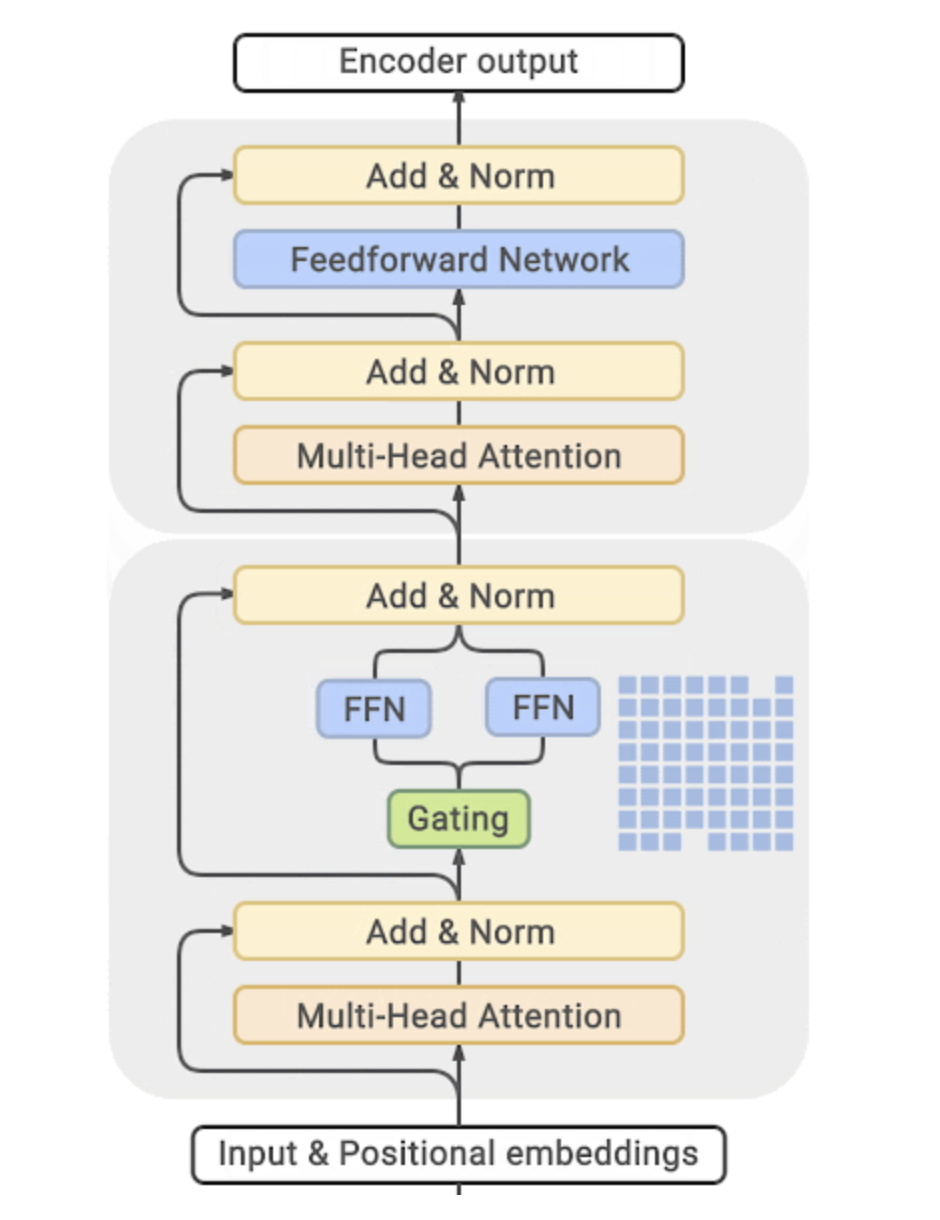

- MoE 방식의 가장 큰 단점은 dense를 사용한 동일한 모델 대비 거의 10배 큰 엄청난 양의 GPU 메모리가 필요하다는 것이다. 이에 훨씬 더 높은 메모리 요구 사항을 극복하기 위해 대한 다양한 distillation 등 접근방식이 제안되었다.
- 이러한 trade-off가 있지만, 수십 혹은 수백의 전문가가 5배 작은 모델로 이어지는 대신 2-3배 작은 기본 모델을 가진 소수의 전문가만 사용할 수 있으므로 교육 속도를 적당히 높이면서 메모리 요구 사항도 적당히 늘릴 수 있다.
- 대부분의 관련 논문 및 구현은 Tensorflow/TPU를 중심으로 구축되어 있으나, PyTorch에서도 DeepSpeed-MoE가 구현되어 있다.

### Pytorch native attention과 Flash attention 사용하기

- PyTorch 2.0은 메모리 효율적인 attention과 flash attention과 같이 융합 GPU 커널을 사용할 수 있는 네이티브 torch.nn.functional.scaled_dot_product_attention(SDPA)를 출시했다.
- optimum 패키지를 설치한 후에는 PyTorch의 native attention을 사용할 수 있도록 관련 내부 모듈을 교체할 수 있다:
```python
model = model.to_bettertransformer()
```

한번 변환을 완료하면 일반적인 방법과 마찬가지로 모델을 사용할 수 있다.



# Setup

## [HF_TOKEN](https://huggingface.co/settings/tokens)

In [19]:
import os

os.environ["HF_TOKEN"] = ""

## clean_memory

In [27]:
def clean_memory():
  import gc
  import torch

  for key in list(globals().keys()):
    if key not in ['clean_memory', '__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'gc', '_1', '_i2', '_i3']:
      del globals()[key]

  # GC(Garbage Collection) 사용
  gc.collect()
  # CUDA 메모리 해제
  torch.cuda.empty_cache()

clean_memory()


## Install

In [21]:
!pip install -U accelerate evaluate datasets schedulefree huggingface_hub

# [예제1](https://medium.com/@geronimo7/llms-multi-gpu-inference-with-accelerate-5a8333e4c5db)

## Hello World example
- This section introduces the basic setup and a simple example to demonstrate multi-GPU “message passing” using Accelerate.

In [28]:
from accelerate import Accelerator
from accelerate.utils import gather_object

accelerator = Accelerator()

In [29]:
# each GPU creates a string
message=[ f"Hello this is GPU {accelerator.process_index}" ]
message

['Hello this is GPU 0']

In [30]:
# collect the messages from all GPUs
messages=gather_object(message)
messages

['Hello this is GPU 0']

In [31]:
# output the messages only on the main process with accelerator.print()
accelerator.print(messages)

['Hello this is GPU 0']


In [32]:
clean_memory()

## Multi GPU inference (simple)
- The following is a simple, non-batched approach to inference.

In [33]:
from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from statistics import mean
import torch, time, json

accelerator = Accelerator()

In [34]:
# 10*10 Prompts. Source: https://www.penguin.co.uk/articles/2022/04/best-first-lines-in-books
prompts_all=[
    "The King is dead. Long live the Queen.",
    "Once there were four children whose names were Peter, Susan, Edmund, and Lucy.",
    "The story so far: in the beginning, the universe was created.",
    "It was a bright cold day in April, and the clocks were striking thirteen.",
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "The sweat wis lashing oafay Sick Boy; he wis trembling.",
    "124 was spiteful. Full of Baby's venom.",
    "As Gregor Samsa awoke one morning from uneasy dreams he found himself transformed in his bed into a gigantic insect.",
    "I write this sitting in the kitchen sink.",
    "We were somewhere around Barstow on the edge of the desert when the drugs began to take hold.",
] * 10

len(prompts_all)

100

In [35]:
# load a base model and tokenizer
model_path = "meta-llama/Llama-2-7b-hf"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map={"": accelerator.process_index},
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [36]:
# sync GPUs and start the timer
accelerator.wait_for_everyone()
start=time.time()

# divide the prompt list onto the available GPUs
with accelerator.split_between_processes(prompts_all) as prompts:
    # store output of generations in dict
    results=dict(outputs=[], num_tokens=0)

    # have each GPU do inference, prompt by prompt
    for prompt in prompts:
        prompt_tokenized=tokenizer(prompt, return_tensors="pt").to("cuda")
        output_tokenized = model.generate(**prompt_tokenized, max_new_tokens=100)[0]

        # remove prompt from output
        output_tokenized=output_tokenized[len(prompt_tokenized["input_ids"][0]):]

        # store outputs and number of tokens in result{}
        results["outputs"].append( tokenizer.decode(output_tokenized) )
        results["num_tokens"] += len(output_tokenized)

    results=[ results ] # transform to list, otherwise gather_object() will not collect correctly


In [37]:
# collect results from all the GPUs
results_gathered=gather_object(results)

if accelerator.is_main_process:
    timediff=time.time()-start
    num_tokens=sum([r["num_tokens"] for r in results_gathered ])

    print(f"tokens/sec: {num_tokens//timediff}, time {timediff}, total tokens {num_tokens}, total prompts {len(prompts_all)}")


tokens/sec: 17.0, time 576.0537829399109, total tokens 10000, total prompts 100


In [38]:
clean_memory()

## Multi GPU inference (batched)
- In a real-world rather than hello-world example one would use batched inference to speed things up.

In [39]:
from accelerate import Accelerator
from accelerate.utils import gather_object
from transformers import AutoModelForCausalLM, AutoTokenizer
from statistics import mean
import torch, time, json

accelerator = Accelerator()

In [40]:
# 10*10 Prompts. Source: https://www.penguin.co.uk/articles/2022/04/best-first-lines-in-books
prompts_all=[
    "The King is dead. Long live the Queen.",
    "Once there were four children whose names were Peter, Susan, Edmund, and Lucy.",
    "The story so far: in the beginning, the universe was created.",
    "It was a bright cold day in April, and the clocks were striking thirteen.",
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "The sweat wis lashing oafay Sick Boy; he wis trembling.",
    "124 was spiteful. Full of Baby's venom.",
    "As Gregor Samsa awoke one morning from uneasy dreams he found himself transformed in his bed into a gigantic insect.",
    "I write this sitting in the kitchen sink.",
    "We were somewhere around Barstow on the edge of the desert when the drugs began to take hold.",
] * 10

len(prompts_all)

100

In [41]:
# load a base model and tokenizer
model_path = "meta-llama/Llama-2-7b-hf"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map={"": accelerator.process_index},
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
# batch, left pad (for inference), and tokenize
def prepare_prompts(prompts, tokenizer, batch_size=16):
    batches=[prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]
    batches_tok=[]
    tokenizer.padding_side="left"
    for prompt_batch in batches:
        batches_tok.append(
            tokenizer(
                prompt_batch,
                return_tensors="pt",
                padding='longest',
                truncation=False,
                pad_to_multiple_of=8,
                add_special_tokens=False).to("cuda")
            )
    tokenizer.padding_side="right"
    return batches_tok


In [43]:
# sync GPUs and start the timer
accelerator.wait_for_everyone()
start=time.time()

# divide the prompt list onto the available GPUs
with accelerator.split_between_processes(prompts_all) as prompts:
    results=dict(outputs=[], num_tokens=0)

    # have each GPU do inference in batches
    prompt_batches=prepare_prompts(prompts, tokenizer, batch_size=16)

    for prompts_tokenized in prompt_batches:
        outputs_tokenized=model.generate(**prompts_tokenized, max_new_tokens=100)

        # remove prompt from gen. tokens
        outputs_tokenized=[ tok_out[len(tok_in):]
            for tok_in, tok_out in zip(prompts_tokenized["input_ids"], outputs_tokenized) ]

        # count and decode gen. tokens
        num_tokens=sum([ len(t) for t in outputs_tokenized ])
        outputs=tokenizer.batch_decode(outputs_tokenized)

        # store in results{} to be gathered by accelerate
        results["outputs"].extend(outputs)
        results["num_tokens"] += num_tokens

    results=[ results ] # transform to list, otherwise gather_object() will not collect correctly


In [44]:
# collect results from all the GPUs
results_gathered=gather_object(results)

if accelerator.is_main_process:
    timediff=time.time()-start
    num_tokens=sum([r["num_tokens"] for r in results_gathered ])

    print(f"tokens/sec: {num_tokens//timediff}, time elapsed: {timediff}, num_tokens {num_tokens}")


tokens/sec: 206.0, time elapsed: 48.38571763038635, num_tokens 10000


In [45]:
clean_memory()

# [예제2](https://github.com/huggingface/accelerate/tree/main/examples)

## [Create a configuration](https://jarvislabs.ai/blogs/accelerate#create-a-configuration)
- 🤗 accelerate uses a config file for managing how to run the PyTorch program.
```shell
# colab이 아닌 경우
accelerate config
```

- default_config.yaml 확인 및 필요시 수정

In [46]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [47]:
!mv /root/.cache/huggingface/accelerate/default_config.yaml /content/

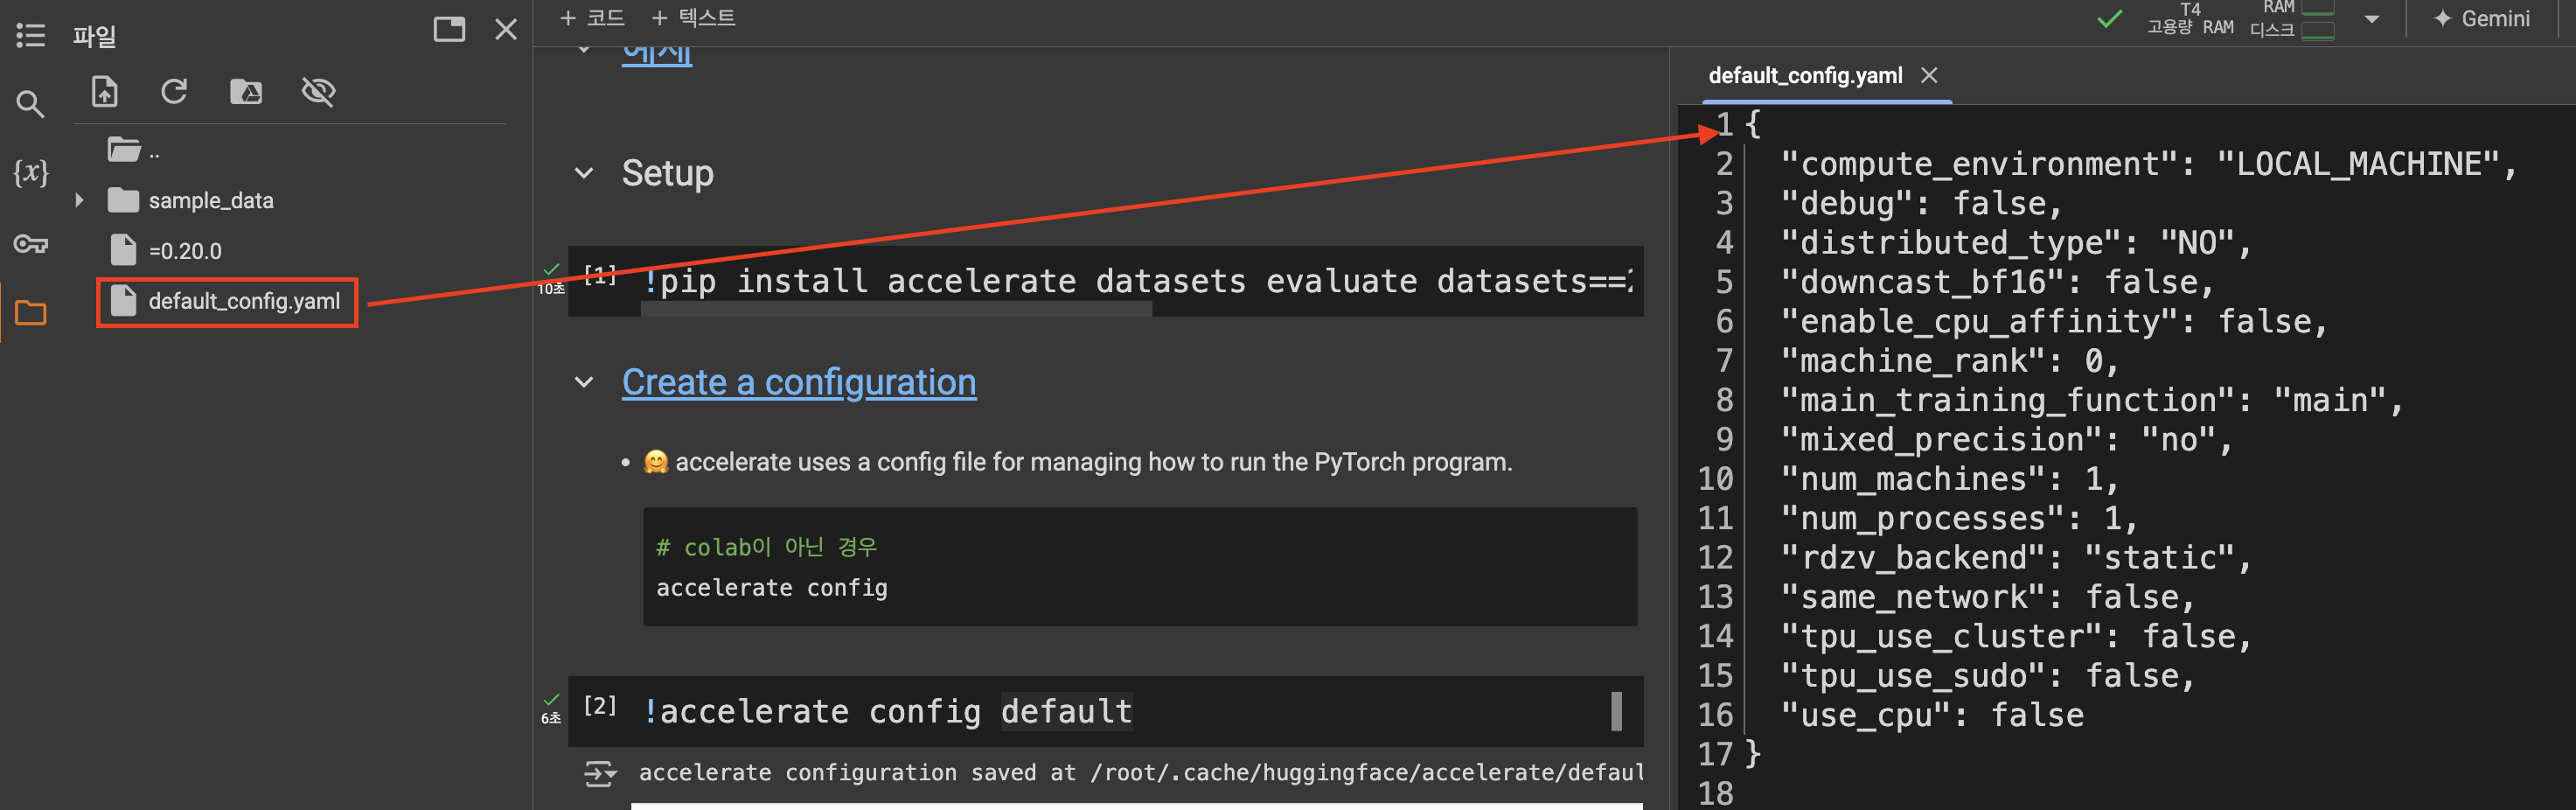

- default_config.yaml 적용

In [48]:
# 수정된 파일 복사
!mv /content/default_config.yaml /root/.cache/huggingface/accelerate/
# 수정된 내용 적용
!accelerate config update

Sucessfully updated the configuration file at /root/.cache/huggingface/accelerate/default_config.yaml.


In [49]:
import argparse

import evaluate
import torch
from datasets import load_dataset #, load_metric
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

from accelerate import Accelerator, DistributedType

In [50]:
MAX_GPU_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 32

## Datasets

- [glue](https://huggingface.co/datasets/nyu-mll/glue)

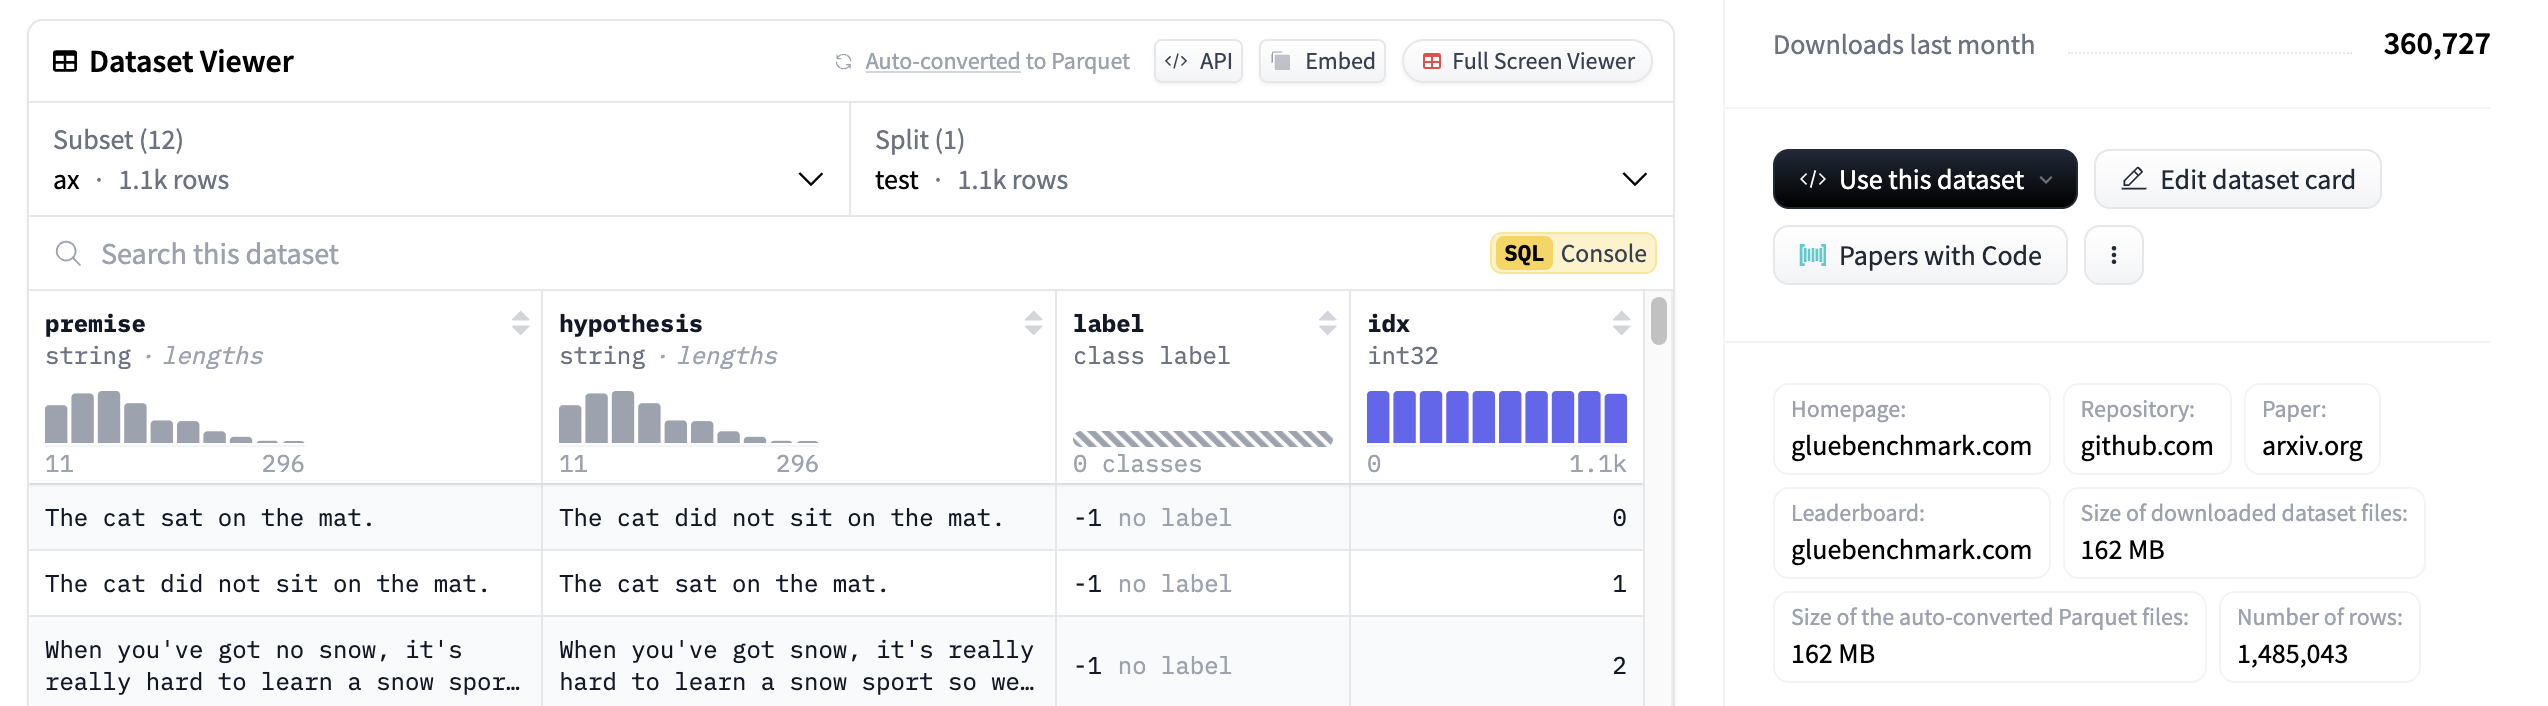

- [mrpc](https://huggingface.co/datasets/SetFit/mrpc)

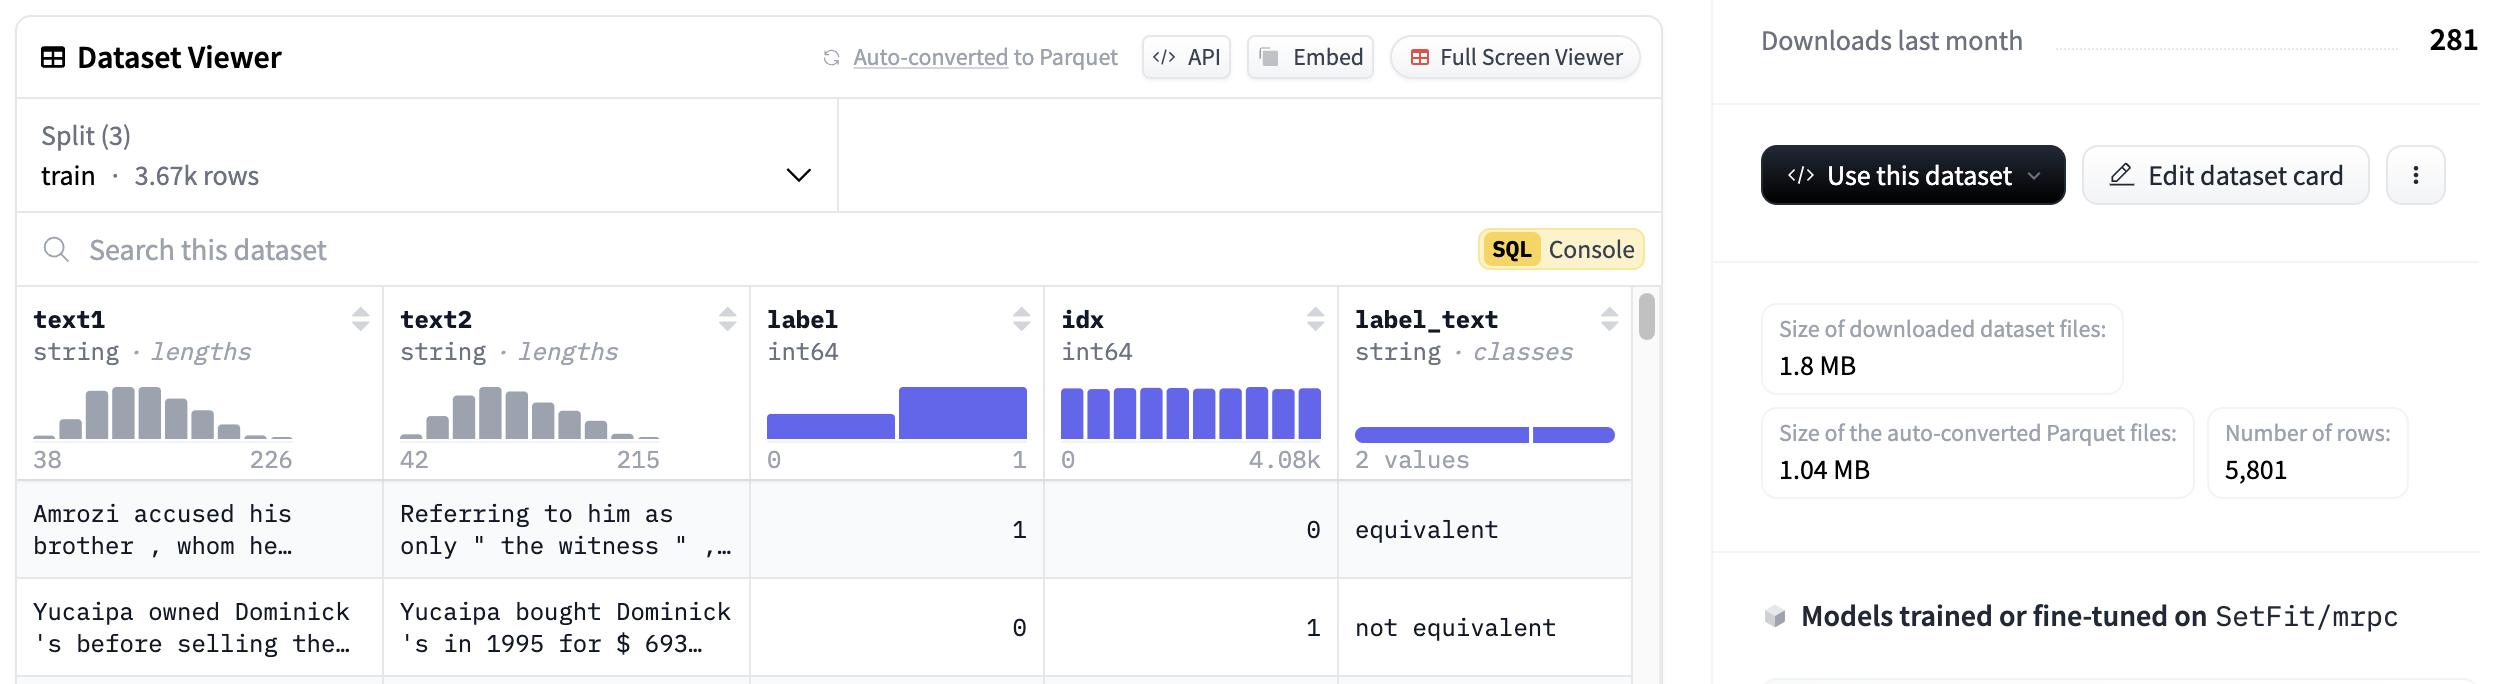

In [53]:
datasets = load_dataset("glue", "mrpc")

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [56]:
datasets.keys()

dict_keys(['train', 'validation', 'test'])

In [58]:
len(datasets['train']), len(datasets['validation']), len(datasets['test'])

(3668, 408, 1725)

In [59]:
datasets['train'][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

## tokenizer

In [60]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [62]:
outputs = tokenizer(datasets['train']["sentence1"], datasets['train']["sentence2"], truncation=True, max_length=None)

In [66]:
len(outputs)

3

## DataLoader

In [67]:
def get_dataloaders(accelerator: Accelerator, batch_size: int = 16):
    """
    Creates a set of `DataLoader`s for the `glue` dataset,
    using "bert-base-cased" as the tokenizer.

    Args:
        accelerator (`Accelerator`):
            An `Accelerator` object
        batch_size (`int`, *optional*):
            The batch size for the train and validation DataLoaders.
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    datasets = load_dataset("glue", "mrpc")

    def tokenize_function(examples):
        # max_length=None => use the model max length (it's actually the default)
        outputs = tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, max_length=None)
        return outputs

    # Apply the method we just defined to all the examples in all the splits of the dataset
    # starting with the main process first:
    with accelerator.main_process_first():
        tokenized_datasets = datasets.map(
            tokenize_function,
            batched=True,
            remove_columns=["idx", "sentence1", "sentence2"],
        )

    # We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
    # transformers library
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    def collate_fn(examples):
        # For Torchxla, it's best to pad everything to the same length or training will be very slow.
        max_length = 128 if accelerator.distributed_type == DistributedType.XLA else None
        # When using mixed precision we want round multiples of 8/16
        if accelerator.mixed_precision == "fp8":
            pad_to_multiple_of = 16
        elif accelerator.mixed_precision != "no":
            pad_to_multiple_of = 8
        else:
            pad_to_multiple_of = None

        return tokenizer.pad(
            examples,
            # Pad to the longest sequence in the batch (or no padding if only a single sequence if provided).
            padding="longest",
            max_length=max_length,
            #  If set will pad the sequence to a multiple of the provided value. Requires padding to be activated.
            pad_to_multiple_of=pad_to_multiple_of,
            return_tensors="pt",
        )

    # Instantiate dataloaders.
    train_dataloader = DataLoader(
        tokenized_datasets["train"],
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=batch_size,
        drop_last=True
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"],
        shuffle=False,
        collate_fn=collate_fn,
        batch_size=EVAL_BATCH_SIZE,
        drop_last=(accelerator.mixed_precision == "fp8"),
    )

    return train_dataloader, eval_dataloader


## training_function

- Accelerator

```python
from accelerate import Accelerator

accelerator = Accelerator()
```

- device

```python
- device = "cuda"
+ device = accelerator.device
  model.to(device)
```

- Prepare PyTorch objects

```python
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
    model, optimizer, training_dataloader, scheduler
)
```

- Training loop -> backward()

```python
-   inputs = inputs.to(device)
-   targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
-   loss.backward()
+   accelerator.backward(loss)
```

In [68]:
from tqdm.auto import tqdm

In [69]:
def training_function(config, args):
    # Initialize accelerator
    accelerator = Accelerator(cpu=args.cpu, mixed_precision=args.mixed_precision)
    # Sample hyper-parameters for learning rate, batch size, seed and a few other HPs
    lr = config["lr"]
    num_epochs = int(config["num_epochs"])
    seed = int(config["seed"])
    batch_size = int(config["batch_size"])

    metric = evaluate.load("glue", "mrpc")
    # metric = load_metric("glue", "mrpc")

    # If the batch size is too big we use gradient accumulation
    gradient_accumulation_steps = 1
    if batch_size > MAX_GPU_BATCH_SIZE and accelerator.distributed_type != DistributedType.XLA:
        gradient_accumulation_steps = batch_size // MAX_GPU_BATCH_SIZE
        batch_size = MAX_GPU_BATCH_SIZE

    set_seed(seed)
    train_dataloader, eval_dataloader = get_dataloaders(accelerator, batch_size)
    # Instantiate the model (we build the model here so that the seed also control new weights initialization)
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", return_dict=True)

    # We could avoid this line since the accelerator is set with `device_placement=True` (default value).
    # Note that if you are placing tensors on devices manually, this line absolutely needs to be before the optimizer
    # creation otherwise training will not work on TPU (`accelerate` will kindly throw an error to make us aware of that).
    model = model.to(accelerator.device)
    # Instantiate optimizer
    optimizer = AdamW(params=model.parameters(), lr=lr)

    # Instantiate scheduler
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=(len(train_dataloader) * num_epochs) // gradient_accumulation_steps,
    )

    # Prepare everything
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.

    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
    )

    # Now we train the model
    for epoch in tqdm(range(num_epochs), desc="epoch"):
        model.train()
        for step, batch in enumerate(train_dataloader):
            # We could avoid this line since we set the accelerator with `device_placement=True`.
            batch.to(accelerator.device)
            outputs = model(**batch)
            loss = outputs.loss
            loss = loss / gradient_accumulation_steps
            accelerator.backward(loss)
            if step % gradient_accumulation_steps == 0:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

        model.eval()
        for step, batch in enumerate(eval_dataloader):
            # We could avoid this line since we set the accelerator with `device_placement=True`.
            batch.to(accelerator.device)
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            predictions, references = accelerator.gather_for_metrics((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions,
                references=references,
            )

        eval_metric = metric.compute()
        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}:", eval_metric)

    accelerator.end_training()


## main

In [70]:
def main():
    parser = argparse.ArgumentParser(description="Simple example of training script.")
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16", "fp8"],
        help="Whether to use mixed precision. Choose"
        "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
        "and an Nvidia Ampere GPU.",
    )
    parser.add_argument("--cpu", action="store_true", help="If passed, will train on the CPU.")
    parser.add_argument(
        "--checkpointing_steps",
        type=str,
        default=None,
        help="Whether the various states should be saved at the end of every n steps, or 'epoch' for each epoch.",
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help="If the training should continue from a checkpoint folder.",
    )
    parser.add_argument(
        "--use_stateful_dataloader",
        action="store_true",
        help="If the dataloader should be a resumable stateful dataloader.",
    )
    parser.add_argument(
        "--with_tracking",
        action="store_true",
        help="Whether to load in all available experiment trackers from the environment and use them for logging.",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default=".",
        help="Optional save directory where all checkpoint folders will be stored. Default is the current working directory.",
    )
    parser.add_argument(
        "--project_dir",
        type=str,
        default="logs",
        help="Location on where to store experiment tracking logs` and relevent project information",
    )
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args() # jupyter notebook인 경우
    config = {"lr": 2e-5, "num_epochs": 3, "seed": 42, "batch_size": 16}

    training_function(config, args)


In [71]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0: {'accuracy': 0.7647058823529411, 'f1': 0.8072289156626506}
epoch 1: {'accuracy': 0.8553921568627451, 'f1': 0.8981001727115717}
epoch 2: {'accuracy': 0.8676470588235294, 'f1': 0.906896551724138}
